In [1]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.datasets as Datasets
import torchvision.utils as vutils
from torch import nn
import numpy as np
import matplotlib.animation as animation


from RES_VAE_Dynamic import VAE
from synth import NvidiaDataset
import matplotlib.pyplot as plt
import os

In [2]:
#image_size = 1
ch_multi = 32
num_res_blocks = 1
latent_channels = 12
block_widths=(1, 2, 4, 8, 8)
lr=1e-4
kl_scale=0.001
load_checkpoint=True
deep_model=False

In [3]:
device = torch.device("cpu")

In [4]:
os.getcwd()

'/ritter/share/projects/larschen/CNN-VAE'

In [5]:
vae_net = VAE(latent_channels=latent_channels, ch=ch_multi, blocks=block_widths, deep_model=False).to(device)

In [7]:
checkpoint = torch.load("Models/FConv_LC12_12488_dks5_128x192x128_copy.pt", map_location=device)
vae_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
num_model_params = 0
for param in vae_net.parameters():
    num_model_params += param.flatten().shape[0]
    
num_model_params/1e6

16.693781

In [9]:
test_set = NvidiaDataset()

test_loader = Subset(test_set, np.arange(4500,5000))
test_loader = DataLoader(test_set, batch_size=2, shuffle=True)

# Get a test image batch from the test_loader to visualise the reconstruction quality etc
dataiter = iter(test_loader)
test = next(dataiter)
test_images = test['image'].float().to(device)
test_ventricle_volume = test['ventricle_volume'].float().to(device)
test_brain_volume = test['brain_volume'].float().to(device)

In [10]:
vae_net.eval();
encoding = vae_net.encoder(torch.tensor(test_images).to(device))

/home/lars/anaconda3/envs/dscm/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Text(0.5, 0, 'Latent Space Standard Deviation')

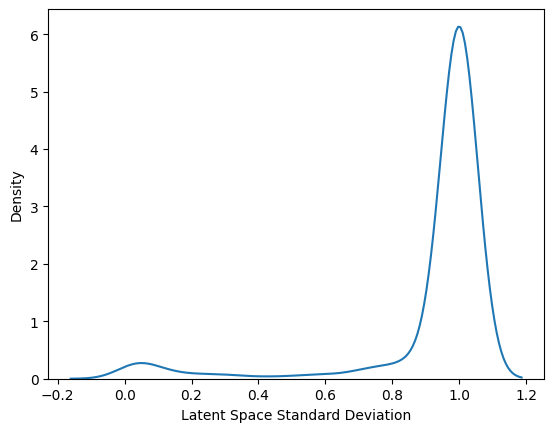

In [11]:
import seaborn as sns
sns.kdeplot(np.exp(np.array(encoding[2][0].detach()).flatten()));
plt.xlabel("Latent Space Standard Deviation")
#plt.yscale('log')

interpolate between brains

In [24]:
n = 11
# latent_interp = torch.zeros((n, 64, 8, 12, 8))
latent_interp = torch.zeros((n, 12, 4, 6, 4))

vent_interp = torch.zeros(n)
brain_interp = torch.zeros(n)

first = encoding[0][0].unsqueeze(0)
last = encoding[0][1].unsqueeze(0)

diff = last - first
for i,fraction in enumerate(torch.linspace(0,1 + 1/n,n)):
    latent_interp[i] = first + diff*fraction
    vent_interp[i] = test_ventricle_volume[0]+(test_ventricle_volume[1] - test_ventricle_volume[0])*fraction
    brain_interp[i] = test_brain_volume[0]+(test_brain_volume[1] - test_brain_volume[0])*fraction

In [25]:
interp_imgs = torch.zeros(n,1,128,192,128)
for i in range(n):
    interp_imgs[i] = vae_net.decoder(latent_interp[i].unsqueeze(0), vent_interp[i].unsqueeze(0), brain_interp[i].unsqueeze(0))

In [26]:
interp = interp_imgs.detach().numpy()

In [ ]:
gif_img = np.zeros()

In [40]:
28*28/30

26.133333333333333

In [42]:
192*128*128/(12*4*6*4)

2730.6666666666665

MovieWriter ffmpeg unavailable; using Pillow instead.


....Done!
.

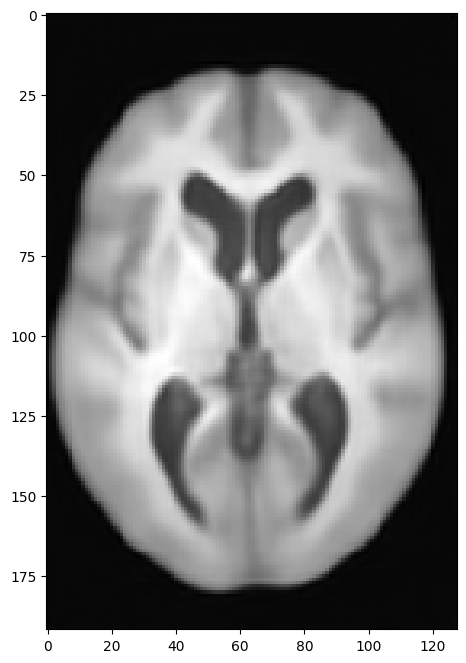

In [33]:
fps = 5

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = np.flip(interp[0,0,:,:,60].T)
im = plt.imshow(a, "gray")

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(np.flip(interp[i,0,:,:,60].T))
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = 11,
                               interval = 1000 / fps, # in ms
                               )

anim.save('test_anim.gif', fps=fps)

print('Done!')


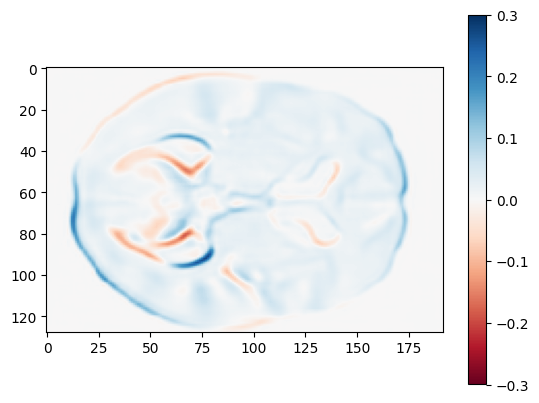

In [48]:
plt.imshow((interp[0]-interp[5])[0,:,:,60], "RdBu", vmin=-0.3,vmax=0.3)
plt.colorbar()

interpolate between conditioned variables

In [19]:
test_brain_volume[1]

tensor(0.5305)

In [20]:
n = 4
#latent_interp = torch.zeros((n, 64, 8, 12, 8))
latent_interp = torch.zeros((n, 12, 4, 6, 4))

vent_interp = torch.zeros(n)
brain_interp = torch.zeros(n)

first = encoding[1][0].unsqueeze(0)

#diff = last - first
for i,fraction in enumerate(torch.linspace(0,1 + 1/n,n)):
    latent_interp[i] = first #+ diff*fraction
    vent_interp[i] = test_ventricle_volume[1]
    brain_interp[i] = torch.linspace(0,1,n)[i]

In [21]:
interp_imgs = torch.zeros(n,1,128,192,128)
for i in range(n):
    interp_imgs[i] = vae_net.decoder(latent_interp[i].unsqueeze(0), vent_interp[i].unsqueeze(0), brain_interp[i].unsqueeze(0))

In [24]:
interp_cond = interp_imgs.detach().numpy()

MovieWriter ffmpeg unavailable; using Pillow instead.


..Done!
.

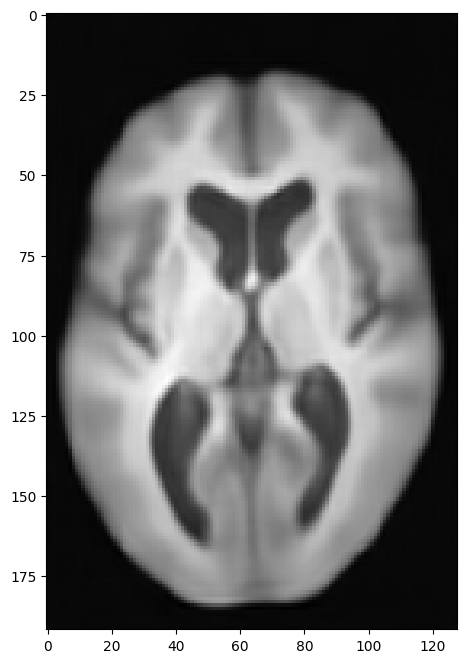

In [25]:
import matplotlib.animation as animation

fps = 5

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

#a = np.flip(np.flip(interp_cond[0,0,:,81,:].T))
#a = np.flip(np.flip(interp_cond[0,0,64,:,:].T))
a = np.flip(np.flip(interp_cond[0,0,:,:,64].T))
im = plt.imshow(a, "gray")

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    #im.set_array(np.flip(interp_cond[i,0,:,81,:].T))
    #im.set_array(np.flip(interp_cond[i,0,64,:,:].T))
    im.set_array(np.flip(interp_cond[i,0,:,:,64].T))

    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n,
                               interval = 1000 / fps, # in ms
                               )

anim.save('cond.gif', fps=fps)

print('Done!')


In [174]:
img = interp_cond[0][0,:,:,64].copy()
img2 = interp_cond[-1][0,:,:,64].copy()

img2[img2<0.17] = 0
img[img<0.17] = 0

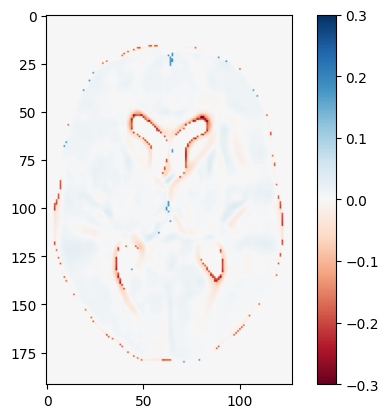

In [179]:
plt.imshow(np.flip(img2.T)-np.flip(img.T), "RdBu",vmin=-0.3, vmax=0.3)
plt.colorbar()

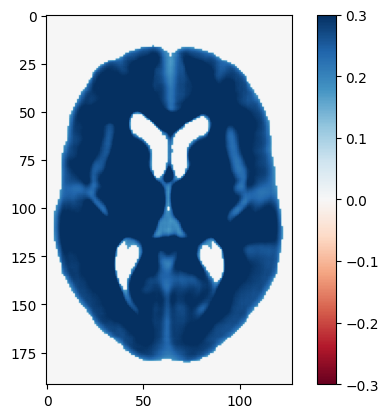

In [176]:
plt.imshow(np.flip(img2.T), "RdBu",vmin=-0.3, vmax=0.3)
plt.colorbar()

In [60]:
np.flip(interp_cond[-2].T)[60,60,64]

array([0.15201572], dtype=float32)

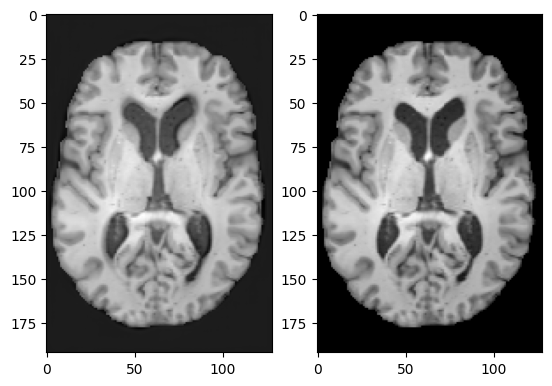

In [55]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(np.flip(test_images[0,0,:,:,64].detach().numpy().T)+np.flip((interp_cond[-2]-interp_cond[0])[0,:,:,64]).T, "gray")
axs[1].imshow(np.flip(test_images[0,0,:,:,64].detach().numpy().T), "gray")

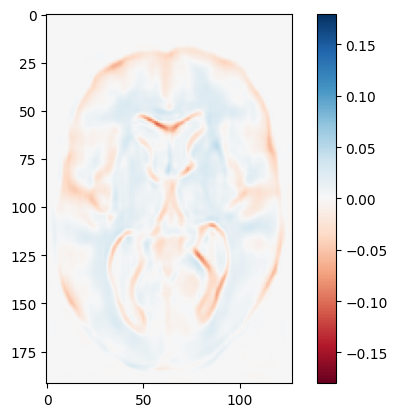

In [31]:
plt.imshow(np.flip((interp_cond[0]-interp_cond[-1])[0,:,:,64]).T, "RdBu", vmin=-0.18,vmax=0.18)
plt.colorbar()


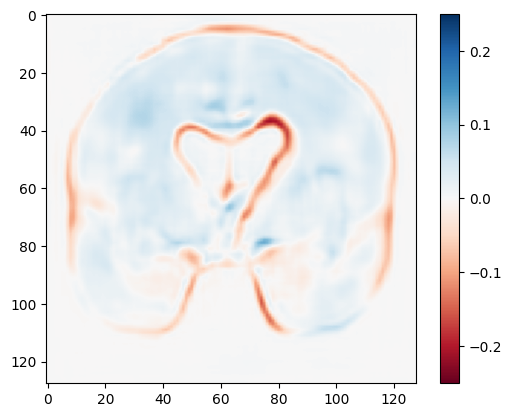

In [41]:
plt.imshow((np.flip(interp_cond[-1]-interp_cond[0])[0,:,81,:].T), "RdBu", vmin=-0.25,vmax=0.25)
plt.colorbar()